In [9]:
#KAEYRYNA ARYSSA BINTI KAEYDA

from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import binned_statistic_2d


In [10]:
dat = Table.read('data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits', format='fits')
df = dat.to_pandas()

print(df)

x_2 = df['x']**2
y_2 = df['y']**2
df['r_gal'] = np.sqrt(x_2+y_2)

                x          y         z       A_O
0       10.020546 -15.421509 -3.241711  8.428943
1      -13.487837   5.663507 -0.802306  8.671107
2        6.642289  -0.138942 -0.585961  8.891596
3        0.203939   4.112373 -0.147622  8.977195
4      -20.824045   6.971037 -1.758061  8.326950
...           ...        ...       ...       ...
511515   1.533189   0.998079  0.217088  9.102036
511516   1.532199   0.998165  0.216980  9.102036
511517   1.698204  -1.207707  0.121088  9.081205
511518   1.698204  -1.206664  0.121917  9.081205
511519   1.698039  -1.206650  0.121900  9.081205

[511520 rows x 4 columns]


Plotting 2 panel figure

Text(0.5, 1.0, 'Residuals of Linear Fit')

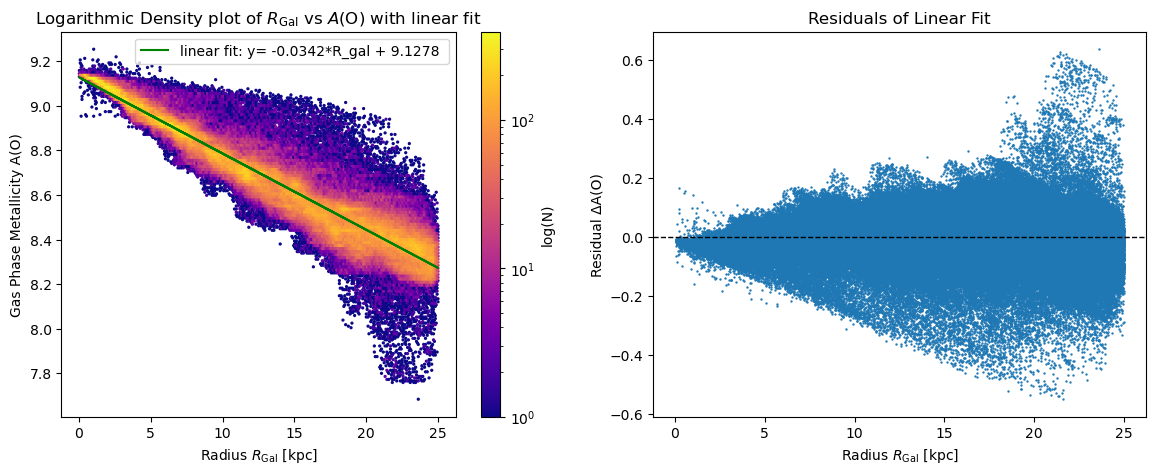

In [13]:
# A) Logarithmic density plot R vs A(O)

def linear_function(x_data, y_data):
    linear_fit = np.polyfit(x_data, y_data, 1)
    m, b = linear_fit
    y_fit = (m * x_data) + b
    return m, b, y_fit

linear_fit = linear_function(df['r_gal'], df['A_O'])
m, b, y_fit = linear_fit

fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex = True)

#logarithmic density plot
ax = axs[0]
hb = ax.hexbin(df['r_gal'], df['A_O'], gridsize=200, cmap='plasma', bins='log')
#Colourbar for density plot, N is data point
cb = plt.colorbar(hb)
cb.set_label('log(N)')

#plot linear fit
ax.plot(df['r_gal'], y_fit, 'g', label=f'linear fit: y= {m:.4f}*R_gal + {b:.4f} ')
ax.set_xlabel(r'Radius $R_{\mathrm{Gal}}$ [kpc]')
ax.set_ylabel('Gas Phase Metallicity A(O)')
ax.set_title(r'Logarithmic Density plot of $R_{\mathrm{Gal}}$ vs $A(\mathrm{O})$ with linear fit')
ax.legend()

# B) Residual of the fit

# Function for linear plotting
def y_predict(intercept, slope, x_data):
    y_model = intercept + slope * x_data
    return y_model

def delta_a (intercept, slope, x_data, y_data):
    y_model = y_predict(intercept, slope, x_data)
    diff_a = y_model - y_data
    return diff_a

#plot model line, for polyfit
df['diff_a'] = delta_a(b, m, df['r_gal'], df['A_O'])

ax = axs[1]
ax.scatter(df['r_gal'], df['diff_a'], label='delta_A', s=0.5)
ax.axhline(0, color='k', linestyle='--', lw=1)
ax.set_xlabel(r'Radius $R_{\mathrm{Gal}}$ [kpc]')
ax.set_ylabel('Residual ΔA(O)')
ax.set_title('Residuals of Linear Fit')


3.2.2 Intercept with slope and uncertainties

In [5]:
# Linear model
x_with_intercept = sm.add_constant(df['r_gal'])  
linear_model = sm.OLS(df['A_O'], x_with_intercept).fit()

# Print linear model summary 
print(linear_model.summary())

# Extract coefficients and uncertainties, and display
intercept, slope = linear_model.params
intercept_unc, slope_unc = linear_model.bse

print(f'Intercept = ({intercept:.4f} ± {intercept_unc:.4f})')
print(f'Slope = ({slope:.4f} ± {slope_unc:.4f})')
print(f'Linear model: y = ({intercept:.4f} ± {intercept_unc:.4f}) + ({slope:.4f} ± {slope_unc:.4f}) x')

df['y_pred'] = linear_model.predict(sm.add_constant(df['r_gal']))

#residual of y for statsmodel
def residual(y_data, y_pred):
    resid = y_pred - y_data
    return resid

df['resid_AO'] = residual(df['A_O'], df['y_pred'])


                            OLS Regression Results                            
Dep. Variable:                    A_O   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 5.337e+06
Date:                Sun, 05 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:21:15   Log-Likelihood:             6.1547e+05
No. Observations:              511520   AIC:                        -1.231e+06
Df Residuals:                  511518   BIC:                        -1.231e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1278      0.000   3.93e+04      0.0

3.1.3 Root mean squares, goodness of fit, region of large residual

In [ ]:
#root mean square error

#for region of large residual
def mean_square_error(y_data, y_pred):
    mse = np.sum(residual(y_data, y_pred)**2)/len(y_data)
    return mse

def root_mean_square_error(y_data, y_pred):
    rmse = np.sqrt(mean_square_error(y_data, y_pred))
    return rmse

print(f'Root mean square error:{root_mean_square_error( df['A_O'], df['y_pred']):.4f}')

#r-squared value from OLS, to quantify linear fitting performance
r_squared = linear_model.rsquared

print(f'R squared value: {r_squared:.4f} ')


Root mean square error:0.0726
R squared value: 0.9125 


The linear model is shown to fit well with the data as the R2 data has the value 0.9125, and is close to 1, for region with smaller RGal. This means that 91.25%  variation of the  A(O) data can be explained with the model. From the plotted logarithmic density plot in 3.1.1, we can see that the linear model fits the data at where the density is high, and hence, making the linear model fits well with the data in general. The region 20 kpc <= RGal <= 25kpc, it has larger residual, so this might contribute to the linear fit to have some variation that is not covered by the model. 

Aside from the R2, we also need to take into consideration of the root mean square error for the residual. For the residual, the root mean square error is quite small as it is ~0.07. The root mean square error describes that the predicted A(O) data has small difference from the actual data. We can see from the plot in 3.1.1(b), at a smaller RGal the residual is not large, but as we get to higher RGal , we can see the residual increases. Therefore, at a region with higher residual, the linear model is less suitable to describe the non-linear pattern in the plot, as the metallicity there might follow different mathematical description

3.1.4 2D histogram

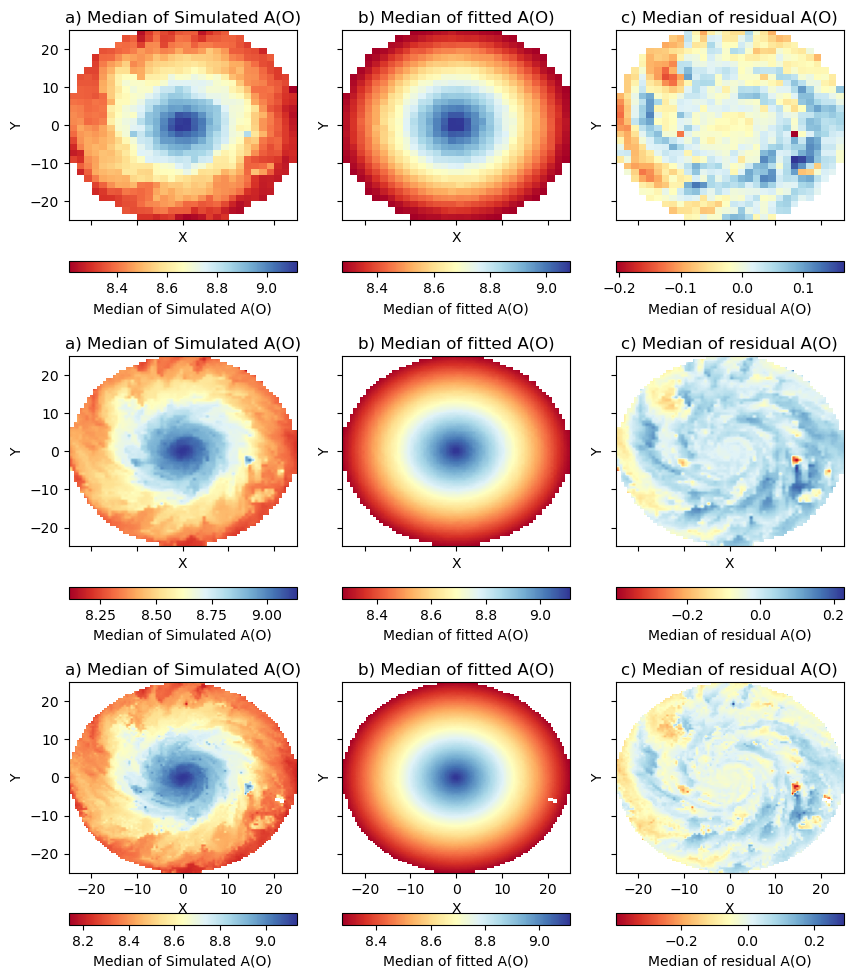

In [8]:
# A) 2D Hist Median simulated


fig, axs = plt.subplots(3, 3, figsize=(10, 12), sharex=True, sharey=True)

bin_compare_1 = 30
bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['A_O'], statistic='median', bins=bin_compare_1)
im = axs[0,0].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[0,0].set_title("a) Median of Simulated A(O)")
axs[0,0].set_xlabel("X")
axs[0,0].set_ylabel("Y")
plt.colorbar(im, ax=axs[0,0], label="Median of Simulated A(O)", orientation='horizontal')

bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['y_pred'], statistic='median', bins=bin_compare_1)
im = axs[0,1].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[0,1].set_title("b) Median of fitted A(O)")
axs[0,1].set_xlabel("X")
axs[0,1].set_ylabel("Y")
plt.colorbar(im, ax=axs[0,1], label="Median of fitted A(O)", orientation='horizontal')


bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['resid_AO'], statistic='median', bins=bin_compare_1)
im = axs[0,2].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[0,2].set_title("c) Median of residual A(O)")
axs[0,2].set_xlabel("X")
axs[0,2].set_ylabel("Y")
plt.colorbar(im, ax=axs[0,2], label="Median of residual A(O)", orientation='horizontal')



#define number of bins to be placed
bin_compare_2 = 70
bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['A_O'], statistic='median', bins=bin_compare_2)
im = axs[1,0].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[1,0].set_title("a) Median of Simulated A(O)")
axs[1,0].set_xlabel("X")
axs[1,0].set_ylabel("Y")
plt.colorbar(im, ax=axs[1,0], label="Median of Simulated A(O)", orientation='horizontal')

bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['y_pred'], statistic='median', bins=bin_compare_2)
im = axs[1,1].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[1,1].set_title("b) Median of fitted A(O)")
axs[1,1].set_xlabel("X")
axs[1,1].set_ylabel("Y")
plt.colorbar(im, ax=axs[1,1], label="Median of fitted A(O)", orientation='horizontal')

bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['resid_AO'], statistic='median', bins=bin_compare_2)
im = axs[1,2].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[1,2].set_title("c) Median of residual A(O)")
axs[1,2].set_xlabel("X")
axs[1,2].set_ylabel("Y")
plt.colorbar(im, ax=axs[1,2], label="Median of residual A(O)", orientation='horizontal')

#defince number of bins to be placed
bin_compare_3 = 100

bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['A_O'], statistic='median', bins=bin_compare_3)
im = axs[2,0].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[2,0].set_title("a) Median of Simulated A(O)")
axs[2,0].set_xlabel("X")
axs[2,0].set_ylabel("Y")
plt.colorbar(im, ax=axs[2,0], label="Median of Simulated A(O)", orientation='horizontal')

bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['y_pred'], statistic='median', bins=bin_compare_3)
im = axs[2,1].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[2,1].set_title("b) Median of fitted A(O)")
axs[2,1].set_xlabel("X")
axs[2,1].set_ylabel("Y")
plt.colorbar(im, ax=axs[2,1], label="Median of fitted A(O)", orientation='horizontal')

bin_stat_median, xedges, yedges, binnumber = binned_statistic_2d(df['x'], df['y'], df['resid_AO'], statistic='median', bins=bin_compare_3)
im = axs[2,2].imshow(bin_stat_median.T, origin='lower', aspect='auto',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='RdYlBu')
axs[2,2].set_title("c) Median of residual A(O)")
axs[2,2].set_xlabel("X")
axs[2,2].set_ylabel("Y")
plt.colorbar(im, ax=axs[2,2], label="Median of residual A(O)", orientation='horizontal')

3.1.5 Choice of Bins, and question on bin size

From the plot, we can see that the2D histogram does not give a good estimation on the data point cluster in a certain coordinate as the edge looks blurry, and making the structure of the data vague if we use small bins.

With increasing bin, the plot starts to look finer (have higher resolution). For the task, my choice of bin is 70, as we can see sharp edge and pattern for the plot, and it provides a good visualization on the data point clustering.

As we increase the bin, it was observed that the plot started to have empty spaces since we are slicing the bin very finely, so it is said that the plot does not visualize the data well for the amount of data that we have. A very small bin might fall between the data points that we have, resulting to the white pixels.


3.1.6 Residual Analysis

For the residual plot and the 2D histogram, it can be seen that at smaller RGal the data have small difference compared to the estimated A(O) that was calculated to make the linear fitting. This indicate that at small radius, the linear plot fits the data well.

As we go to higher RGal values, we can see that the data starts to have larger residuals, and this indicate that the linear model is unsuitable to be used to plot the data at these values. A reason for this might be that at the spiral arms of the milky way where stars are formed actively, the metallicity is higher might no longer follow the same slope that the linear model estimated. Therefore, we say at higher RGal the residual is large and the linear model does not  fit the data well.
